In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [4]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [20]:
%cd /content/drive/MyDrive/Colab Notebooks/Data/

/content/drive/MyDrive/Colab Notebooks/Data


In [22]:
!ls

animal10			 Maleria_cell_images.zip
archive.zip			 maleria_mobilenet_weights.h5
bestanimal10predictor.hdf5	 model.h5
cats_and_dogs_filtered		 my_model_weights.h5
cell_images			 __pycache__
chest_xray			 raw-img
chest_xray.zip			 raw-intel-images
intelimage_mobilenet_weights.h5  translate.py
intel_images.zip


In [ ]:
#! unzip chest_xray.zip "chest_Xray_pneumonia/chest_xray/chest_xray/**/*" -d chest_xray/

In [5]:
# Directories
base_path = '/content/drive/MyDrive/Colab Notebooks/Data/chest_xray/chest_Xray_pneumonia/chest_xray/chest_xray/'
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path, 'test/')
val_path = os.path.join(base_path, 'val/')

In [33]:
os.path.isdir('chest_xray/chest_Xray_pneumonia/chest_xray/chest_xray/train/.DS_Store')
os.remove('chest_xray/chest_Xray_pneumonia/chest_xray/chest_xray/train/.DS_Store')
os.remove('chest_xray/chest_Xray_pneumonia/chest_xray/chest_xray/test/.DS_Store')
os.remove('chest_xray/chest_Xray_pneumonia/chest_xray/chest_xray/val/.DS_Store')

In [6]:
# Number of files in each category in train test val directory

print("--------------Train------------------")
print("========================================")
for dir in os.listdir(train_path):
  print(dir, len(os.listdir(train_path+dir)))

print("--------------Test------------------")
print("========================================")
for dir in os.listdir(test_path):
  print(dir, len(os.listdir(test_path+dir)))

print("--------------val------------------")
print("========================================")
for dir in os.listdir(val_path):
  print(dir, len(os.listdir(val_path+dir)))

--------------Train------------------
NORMAL 1342
PNEUMONIA 3876
--------------Test------------------
PNEUMONIA 390
NORMAL 234
--------------val------------------
PNEUMONIA 9
NORMAL 9


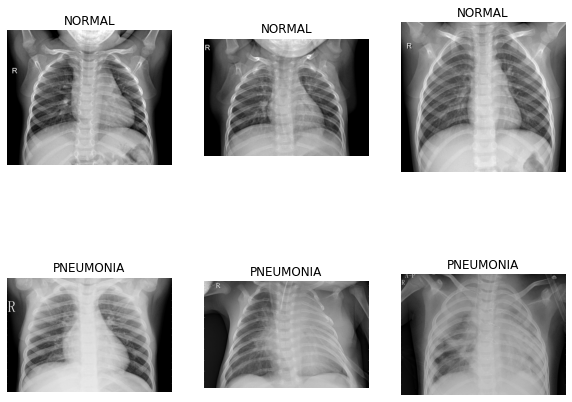

In [7]:
# Show some random files from each train directory
k=1
plt.figure(figsize=(10,8))
for dir in os.listdir(train_path):
  for i in range(3):
    random_img = random.sample(os.listdir(train_path+dir),1)
    img = mpimg.imread(train_path+dir+'/'+random_img[0])

    plt.subplot(2,3,k)
    plt.imshow(img, cmap='gray')
    plt.title(dir)
    plt.axis('off')
    k+=1

plt.show()




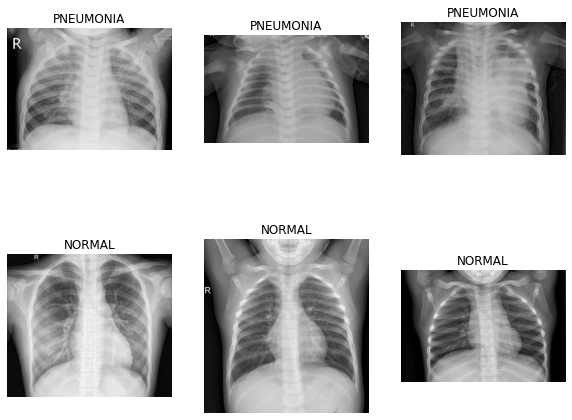

In [8]:
# Show some random files from each test directory
k=1
plt.figure(figsize=(10,8))
for dir in os.listdir(test_path):
  for i in range(3):
    random_img = random.sample(os.listdir(test_path+dir),1)
    img = mpimg.imread(test_path+dir+'/'+random_img[0])

    plt.subplot(2,3,k)
    plt.imshow(img, cmap='gray')
    plt.title(dir)
    plt.axis('off')
    k+=1

plt.show()

In [9]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
#Image Augmentation

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(128,128),
                                                    class_mode='sparse',
                                                    batch_size=50)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(128,128),
                                                  class_mode='sparse',
                                                  batch_size=50)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
# pre-trained model
base_model_mnet = MobileNetV2(input_shape=(224,224,3),
                         weights='imagenet',
                         include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
for layer in base_model_mnet.layers:
  layer.trainable=False

In [12]:
# Model
model_mnet = Sequential()
model_mnet .add(base_model_mnet )
model_mnet .add(GlobalAvgPool2D())
model_mnet .add(Dense(1024, activation='relu'))
model_mnet .add(Dense(2, activation='softmax'))

model_mnet .summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 3,571,778
Trainable params: 1,313,794
Non-trainable params: 2,257,984
_________________________________________________________________


In [94]:
model_mnet .compile(optimizer='adam',
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [95]:
# callbacks
from  tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   mode='min')

In [96]:
hist = model_mnet .fit(train_generator_cnn,
                 steps_per_epoch=160,
                 epochs=10,
                 validation_data=test_generator_cnn,
                 validation_steps=18,
                 verbose=2,
                 callbacks=[es])

Epoch 1/10
160/160 - 249s - loss: 0.2237 - accuracy: 0.9207 - val_loss: 0.2229 - val_accuracy: 0.9045 - 249s/epoch - 2s/step
Epoch 2/10
160/160 - 242s - loss: 0.1097 - accuracy: 0.9555 - val_loss: 0.5005 - val_accuracy: 0.8472 - 242s/epoch - 2s/step
Epoch 3/10
160/160 - 242s - loss: 0.1045 - accuracy: 0.9580 - val_loss: 0.2390 - val_accuracy: 0.8993 - 242s/epoch - 2s/step
Epoch 4/10
160/160 - 241s - loss: 0.1115 - accuracy: 0.9563 - val_loss: 0.3049 - val_accuracy: 0.8802 - 241s/epoch - 2s/step
Epoch 5/10
160/160 - 241s - loss: 0.0887 - accuracy: 0.9678 - val_loss: 0.2526 - val_accuracy: 0.8993 - 241s/epoch - 2s/step
Epoch 6/10
160/160 - 240s - loss: 0.0853 - accuracy: 0.9660 - val_loss: 0.4485 - val_accuracy: 0.8542 - 240s/epoch - 1s/step


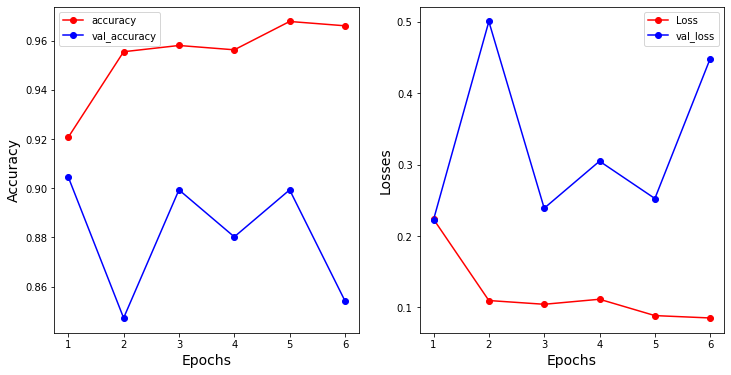

In [97]:
# Plotting accuracy and losses
mnet_acc = hist.history['accuracy']
mnet_loss = hist.history['loss']
mnet_val_acc = hist.history['val_accuracy']
mnet_val_loss = hist.history['val_loss']
epochs = range(1,len(mnet_acc)+1)

fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(epochs, mnet_acc, 'ro-', label='accuracy')
ax[0].plot(epochs, mnet_val_acc, 'bo-', label='val_accuracy')
ax[0].set_xlabel("Epochs", fontsize=14)
ax[0].set_ylabel("Accuracy", fontsize=14)
ax[0].legend()

ax[1].plot(epochs, mnet_loss, 'ro-', label='Loss')
ax[1].plot(epochs, mnet_val_loss, 'bo-', label='val_loss')
ax[1].set_xlabel("Epochs", fontsize=14)
ax[1].set_ylabel("Losses", fontsize=14)
ax[1].legend()

plt.show()

# Training the VGG16 Model

In [55]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(input_shape=(128,128,3),
            weights='imagenet',
            include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable=False

In [63]:
# Model
model_vgg = Sequential()
model_vgg.add(base_model)
model_vgg.add(GlobalAvgPool2D())
model_vgg.add(Dense(1024, activation='relu'))
model_vgg.add(Dense(2, activation='softmax'))

model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_5 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 3,571,778
Trainable params: 1,313,794
Non-trainable params: 2,257,984
_________________________________________________________________


In [64]:
model_vgg.compile(optimizer='adam',
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [65]:
from tensorflow.keras.applications.vgg16 import preprocess_input
train_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator_vgg = train_datagen_vgg.flow_from_directory(train_path,
                                                    target_size=(128,128),
                                                    class_mode='sparse',
                                                    batch_size=50)

test_generator_vgg = test_datagen_vgg.flow_from_directory(test_path,
                                                  target_size=(128,128),
                                                  class_mode='sparse',
                                                  batch_size=50)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [66]:
hist_vgg = model_vgg.fit(train_generator_vgg,
                         steps_per_epoch=104,
                         epochs=10,
                         validation_data=test_generator_vgg,
                         validation_steps=12,
                         verbose=2)

Epoch 1/10
104/104 - 110s - loss: 0.3944 - accuracy: 0.8881 - val_loss: 0.6901 - val_accuracy: 0.7467 - 110s/epoch - 1s/step
Epoch 2/10
104/104 - 106s - loss: 0.1460 - accuracy: 0.9410 - val_loss: 0.6184 - val_accuracy: 0.7700 - 106s/epoch - 1s/step
Epoch 3/10
104/104 - 106s - loss: 0.1254 - accuracy: 0.9508 - val_loss: 0.6599 - val_accuracy: 0.7750 - 106s/epoch - 1s/step
Epoch 4/10
104/104 - 128s - loss: 0.1130 - accuracy: 0.9559 - val_loss: 0.5645 - val_accuracy: 0.7967 - 128s/epoch - 1s/step
Epoch 5/10
104/104 - 141s - loss: 0.1038 - accuracy: 0.9601 - val_loss: 1.0792 - val_accuracy: 0.7233 - 141s/epoch - 1s/step
Epoch 6/10
104/104 - 134s - loss: 0.0799 - accuracy: 0.9723 - val_loss: 0.7690 - val_accuracy: 0.7750 - 134s/epoch - 1s/step
Epoch 7/10
104/104 - 159s - loss: 0.0651 - accuracy: 0.9795 - val_loss: 0.7581 - val_accuracy: 0.7817 - 159s/epoch - 2s/step
Epoch 8/10
104/104 - 119s - loss: 0.0676 - accuracy: 0.9739 - val_loss: 0.8451 - val_accuracy: 0.7933 - 119s/epoch - 1s/step


In [67]:
hist_vgg.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

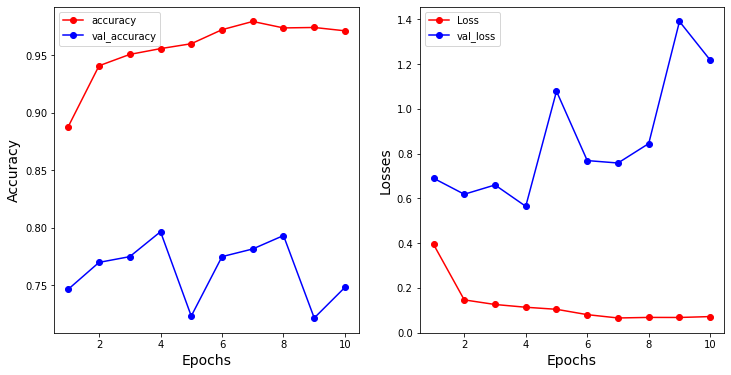

In [69]:
# Plotting accuracy and losses
vgg_acc = hist_vgg.history['accuracy']
vgg_loss = hist_vgg.history['loss']
vgg_val_acc = hist_vgg.history['val_accuracy']
vgg_val_loss = hist_vgg.history['val_loss']
epochs = range(1,len(vgg_acc)+1)

fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(epochs, vgg_acc, 'ro-', label='accuracy')
ax[0].plot(epochs, vgg_val_acc, 'bo-', label='val_accuracy')
ax[0].set_xlabel("Epochs", fontsize=14)
ax[0].set_ylabel("Accuracy", fontsize=14)
ax[0].legend()

ax[1].plot(epochs, vgg_loss, 'ro-', label='Loss')
ax[1].plot(epochs, vgg_val_loss, 'bo-', label='val_loss')
ax[1].set_xlabel("Epochs", fontsize=14)
ax[1].set_ylabel("Losses", fontsize=14)
ax[1].legend()

plt.show()

# Training A CNN Model

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
model_cnn = Sequential()
model_cnn.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model_cnn.add(Conv2D(64,kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(64,kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(128,kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

In [14]:
model_cnn.compile(optimizer='adam',
                  loss=tf.keras.losses.binary_crossentropy,
                  metrics=['accuracy'])

In [15]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_cnn = ImageDataGenerator(rescale=1.0/255.,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

test_datagen_cnn = ImageDataGenerator(rescale=1.0/255.)

train_generator_cnn = train_datagen_cnn.flow_from_directory(train_path,
                                                            target_size=(224,224),
                                                            class_mode='binary',
                                                            batch_size=32)

test_generator_cnn = test_datagen_cnn.flow_from_directory(test_path,
                                                          target_size=(224,224),
                                                          batch_size=32,
                                                          class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
hist_cnn = model_cnn.fit(train_generator_cnn,
                     steps_per_epoch=160,
                     epochs=10,
                     validation_data=test_generator_cnn,
                     validation_steps=18,
                     verbose=2)

Epoch 1/10
160/160 - 1665s - loss: 0.4823 - accuracy: 0.7773 - val_loss: 0.4732 - val_accuracy: 0.7951 - 1665s/epoch - 10s/step
Epoch 2/10
160/160 - 1511s - loss: 0.3519 - accuracy: 0.8500 - val_loss: 0.4949 - val_accuracy: 0.7986 - 1511s/epoch - 9s/step
Epoch 3/10
160/160 - 1512s - loss: 0.2565 - accuracy: 0.8973 - val_loss: 0.5185 - val_accuracy: 0.7743 - 1512s/epoch - 9s/step
Epoch 4/10


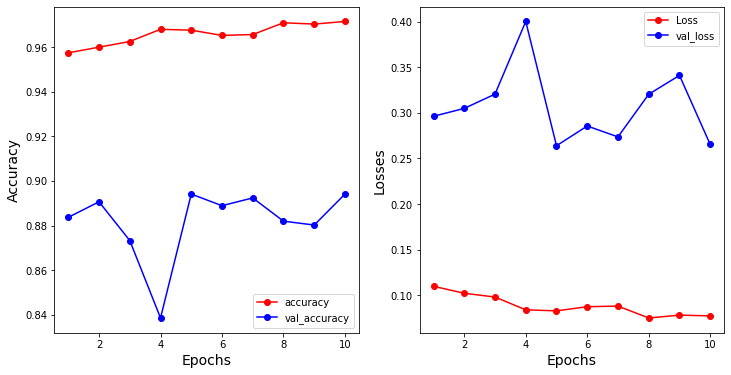

In [85]:
# Plotting accuracy and losses
cnn_acc = hist_cnn.history['accuracy']
cnn_loss = hist_cnn.history['loss']
cnn_val_acc = hist_cnn.history['val_accuracy']
cnn_val_loss = hist_cnn.history['val_loss']
epochs = range(1,len(cnn_acc)+1)

fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(epochs, cnn_acc, 'ro-', label='accuracy')
ax[0].plot(epochs, cnn_val_acc, 'bo-', label='val_accuracy')
ax[0].set_xlabel("Epochs", fontsize=14)
ax[0].set_ylabel("Accuracy", fontsize=14)
ax[0].legend()

ax[1].plot(epochs, cnn_loss, 'ro-', label='Loss')
ax[1].plot(epochs, cnn_val_loss, 'bo-', label='val_loss')
ax[1].set_xlabel("Epochs", fontsize=14)
ax[1].set_ylabel("Losses", fontsize=14)
ax[1].legend()

plt.show()

The CNN model built in this notebook performs better than the Transfer models.
The reason behind this is we have used the imagenet weights in the transfer models. These must be different from the X-ray images that we had to use here for training and testing. So, we do not get any advantage of using transfer models.

In [102]:
!ls test_path

ls: cannot access 'test_path': No such file or directory


In [103]:
train_generator_cnn.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [125]:
class_dict = train_generator.class_indices
def get_key(dict1, val):
  for key,value in dict1.items():
    if val==value:
      return key
  return "key does not exist!"

get_key(class_dict, 1)

'PNEUMONIA'

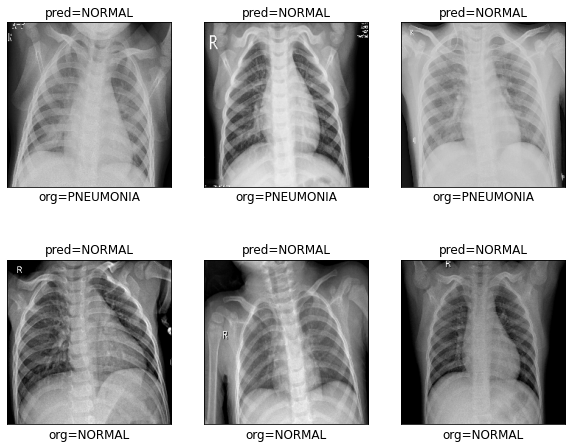

In [135]:
from keras_preprocessing.image.utils import load_img
import random
import matplotlib.image as mpimg

k = 1
#fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,8))
plt.figure(figsize=(10,8))

for dir in os.listdir(train_path):
  for i in range(3):
    random_image = random.sample(os.listdir(train_path+dir),1)
    img = load_img(train_path+dir+'/'+random_image[0], target_size=(224,224))
    i = img_to_array(img)/255.
    img_array = np.array([i])

    pred = model_cnn.predict(img_array)
    plt.subplot(2,3,k)
    plt.imshow(img_array[0])
    plt.title("pred="+str(get_key(class_dict, np.argmax(pred)))  )
    plt.xlabel("org="+str(dir), fontsize=12)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    #ax[k,i].axis('off')
    k+=1

plt.show()

In [145]:
y_actual =[]
y_test =[]

In [146]:
for files in os.listdir(test_path+'NORMAL/'):
  img = load_img(test_path+'NORMAL/'+files, target_size=(224,224))
  i = img_to_array(img)
  i = np.expand_dims(i, axis=0)
  #i = np.array([i])
  p= model_cnn.predict(i)
  if(p[0,0]>0.5):
    x=1
  else:
    x=0
  y_test.append(p[0,0])
  y_actual.append(1)

ValueError: ignored

In [ ]:
y_test

In [143]:
for files in os.listdir(test_path+'PNEUMONIA/'):
  img = load_img(test_path+'PNEUMONIA/'+files, target_size=(224,224))
  i = img_to_array(img)
  i = np.expand_dims(i, axis=0)
  p= model_cnn.predict(i)
  y_test.append(p[0,0])
  y_actual.append(0)

In [144]:
y_test

[0.99999017,
 0.99993265,
 0.9999943,
 0.9989289,
 0.99613786,
 0.99988544,
 0.99985135,
 0.9997909,
 0.99999833,
 0.999997,
 0.9995147,
 0.9998925,
 0.9999436,
 0.9998807,
 0.99904865,
 0.9999615,
 0.9992238,
 0.9999943,
 0.97783065,
 0.9998802,
 0.9987178,
 0.9999219,
 0.99997735,
 0.999997,
 0.9996976,
 0.99999195,
 0.9995151,
 0.9990487,
 0.9999763,
 0.9999783,
 0.9930216,
 0.99998593,
 0.9963734,
 0.9992682,
 0.9999945,
 0.99957997,
 0.9983414,
 0.99997544,
 1.0,
 0.99983174,
 0.99999654,
 0.9997338,
 0.99944746,
 0.99977434,
 0.99995124,
 0.9999132,
 0.99999547,
 0.9988113,
 0.9996723,
 0.999568,
 0.9999877,
 0.98707616,
 0.9999895,
 0.9999989,
 0.99999464,
 0.9998084,
 0.9999826,
 0.9999175,
 0.9973016,
 0.99357486,
 0.99806523,
 0.99968076,
 0.99818015,
 0.99999666,
 0.99950856,
 0.99994063,
 0.9975741,
 0.9998053,
 0.9999993,
 0.9919145,
 1.0,
 0.9999933,
 0.9998154,
 0.9966689,
 0.9997884,
 0.9976624,
 0.99996966,
 0.99976534,
 0.99999535,
 0.998047,
 0.9958185,
 0.9999946,
 

In [109]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_actual, y_test)


ValueError: ignored